# US airports network analysis
This notebook contains a study on the US airports network and its flight connections, during the year 2009. The aim of this project is to represent a wide, complex real-world network as a directed graph. This representation enables the calculation of some performance metrics, expressing the importance and centrality of both nodes and edges, under different assumptions. As a result, airports and routes can be ranked, according to different criteria.

## Research questions
Given the raw dataset, this study answers the following questions:
- which are the most important airports, in terms of population living in the corresponding metropolitan area?
- which airports are more important, in terms of number of connections provided?
- which are the most crowded routes?
- which are on average the most efficient routes?

## Libraries
Special libraries used in this notebook are "networkx", which is a useful package that enables to study large real-world graphs networks, and relations between entities. I also used "cartopy" package to plot the airports network on the undrlaying geographic map. This suite was designed especially to produce geospatial data plots.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature

## The flights dataset
The dataset used for this project derives from the Bureau of Transportation Statistics’ T-100 Domestic Segment records. The original data set was adapted and reduced to the given csv file, for didactic purpose.

Each row of the input dataframe is a flight record, carrying information on the origin airport, destination airport, associated cities (note that one city may refer to more than one airport, and this happens e.g. for the biggest metropolitan cities), the geographical coordinates of both origin and destination, the cities'population, carried passengers, number of seats available on board, date of the flight (with daily resolution).

Flights record range from year 1990 until 2009. It is true that this data set is very out-to-date, but it's still enough for the purpose of practicing graph theory principles and for the plotting part.

As one can expect, we are dealing with a very long dataframe, with thousands of rows.

In [2]:
input_df = pd.read_csv("Airports.csv")
input_df["Fly_date"] = pd.to_datetime(input_df["Fly_date"])
input_df

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3606798,STL,TBN,"St. Louis, MO","Fort Leonard Wood, MO",281,969,51,119,2009-02-01,2828990,46457,38.748699,-90.370003,37.741600,-92.140701
3606799,STL,TBN,"St. Louis, MO","Fort Leonard Wood, MO",245,1026,54,119,2009-11-01,2828990,46457,38.748699,-90.370003,37.741600,-92.140701
3606800,STL,TBN,"St. Louis, MO","Fort Leonard Wood, MO",363,1273,67,119,2009-08-01,2828990,46457,38.748699,-90.370003,37.741600,-92.140701
3606801,CGI,TBN,"Cape Girardeau, MO","Fort Leonard Wood, MO",2,19,1,146,2009-08-01,93712,46457,37.225300,-89.570801,37.741600,-92.140701


## Data preprocessing

### Filter out airports with missing coordinates
Looking at the raw dataframe, the first inconsistency one can notice is that some airports have empty Lat and Lon values.
We can get rid of these rows, since we would not be able to plot the correpsonding edges in the network representation.

In [3]:
missing_lat_lon = input_df[input_df[["Org_airport_lat", "Org_airport_long", "Dest_airport_lat", "Dest_airport_long"]].isna().any(axis=1)]
missing_lat_lon

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
945,RBG,RDM,"Roseburg, OR","Bend, OR",0,0,1,131,2005-10-01,102817,140962,NaN,NaN,44.254101,-121.150002
946,RBG,RDM,"Roseburg, OR","Bend, OR",0,0,1,131,2005-09-01,102817,140962,NaN,NaN,44.254101,-121.150002
947,RBG,RDM,"Roseburg, OR","Bend, OR",0,0,1,131,2005-09-01,102817,140962,NaN,NaN,44.254101,-121.150002
948,RBG,RDM,"Roseburg, OR","Bend, OR",0,0,1,131,2005-10-01,102817,140962,NaN,NaN,44.254101,-121.150002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595391,SCF,PBI,"Phoenix, AZ","West Palm Beach, FL",1,8,1,1955,2007-11-01,4175595,5465183,NaN,NaN,26.683201,-80.095596
3603513,RND,COS,"San Antonio, TX","Colorado Springs, CO",88,120,1,738,2004-05-01,1843927,579810,NaN,NaN,38.805801,-104.700996
3604641,HIK,COS,"Honolulu, HI","Colorado Springs, CO",57,210,1,3355,2006-10-01,903467,601150,NaN,NaN,38.805801,-104.700996
3606576,YIP,PHD,"Detroit, MI","New Philadelphia, OH",2,6,1,164,2006-07-01,8969084,91163,42.237900,-83.530403,NaN,NaN


In [4]:
database = input_df[~input_df.index.isin(missing_lat_lon.index)]

### Check missing data in other columns
Next let's check if other columns contain missing values. If the filtered dataframe is complete, the following command should return True.

In [5]:
database[database.isna().any(axis=1)].empty

True

### Use only most recent data
For the purpose of this analysis, we will use only the most recent records, corresponding to year 2009.

In [6]:
all_years = sorted(database["Fly_date"].dt.year.unique())
print("The dataset contains flights data collected during the following years: {}".format(all_years))

The dataset contains flights data collected during the following years: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009]


In [7]:
year = all_years[-1]

year_data = database[database["Fly_date"].dt.year == year]
year_data = year_data.sort_values(by = "Fly_date")

### Drop inactive routes 
I decided to drop all inactive routes, because they are adding useless records to the dataframe, without providing any additional information for my purpose. A route is considered inactive if no flights were done during the considered year and no passengers were carried at all.

In [8]:
year_data = year_data[(year_data["Flights"] != 0) & (year_data["Passengers"] != 0)]

### Identify passenger flights
In the raw dataset, there is no attribute allowing to distinguish between passenger flights, mail carriers, cargo flights or pleasure flights (e.g. tourism activity) in a direct way. The simplest way to filter only commercial passenger flights, is to select only the rows where the number of available seats is grater than 0 and destination airport is different from origin airport.

There some basic assumptions behind this choice:
- cargo flights don't have passengers seats (unless they are mixed freight and passenger carriers)
- flights taking off and landing to the same airport in the same day may be tourist activity or could provide some kind of service to the local community (e.g. fire watching, rescue, environmental monitoration, and many others).


In [9]:
""" filter out flights with no passenger seats available (e.g. cargo)"""
other_flight = year_data[year_data["Seats"] == 0]
other_flight = other_flight.drop(columns = ["Passengers", "Seats"]).reset_index(drop = True)

passenger_flights =  year_data[year_data["Seats"] > 0].reset_index(drop=True)

In [10]:
""" drop flights returning to the same airport (e.g. tourist flights) """
passenger_flights = passenger_flights[passenger_flights["Origin_airport"]!=passenger_flights["Destination_airport"]]
passenger_flights

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,PHX,JFK,"Phoenix, AZ","New York, NY",3237,4800,30,2153,2009-01-01,4364094,38139592,33.434299,-112.012001,40.639801,-73.778900
1,DCA,CHS,"Washington, DC","Charleston, SC",1490,2600,52,444,2009-01-01,10952482,659191,38.852100,-77.037697,32.898602,-80.040497
2,IAD,CHS,"Washington, DC","Charleston, SC",893,1150,23,441,2009-01-01,10952482,659191,38.944500,-77.455803,32.898602,-80.040497
3,CSG,ELP,"Columbus, GA","El Paso, TX",131,148,1,1255,2009-01-01,292795,751296,32.516300,-84.938904,31.807199,-106.377998
4,CNM,ELP,"Carlsbad, NM","El Paso, TX",51,216,24,129,2009-01-01,52706,751296,32.337502,-104.263000,31.807199,-106.377998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178086,PHX,MCO,"Phoenix, AZ","Orlando, FL",35,54,1,1848,2009-12-01,4364094,2082421,33.434299,-112.012001,28.429399,-81.308998
178087,MSP,ATW,"Minneapolis, MN","Appleton, WI",2912,4000,80,236,2009-12-01,3269814,221894,44.882000,-93.221802,44.258099,-88.519096
178088,SEA,MCO,"Seattle, WA","Orlando, FL",8864,9749,62,2553,2009-12-01,6815696,2082421,47.449001,-122.308998,28.429399,-81.308998
178089,SAN,PHL,"San Diego, CA","Philadelphia, PA",8994,12078,66,2369,2009-12-01,3053793,11936504,32.733601,-117.190002,39.871899,-75.241096


### Some consideration on the data cleaning procedure
Data cleaning has been developed as a sequential process, starting from filtering out missing records, until the selection of passenger flights only. The main purpose was to get rid of useless records and make the network simpler.

The dataset reduction can be estimated as follows:

In [11]:
print("The original dataset contained: {} rows and the new dataset contains {} rows".format(input_df.shape[0], 
                                                                                            passenger_flights.shape[0]))

The original dataset contained: 3606803 rows and the new dataset contains 177776 rows


## Build up the network
### Edges dataframe
The edges of the network represent the flight links between airports. Airports are the nodes of the network. To build up the edges dataframe, we can proceed by grouping the flight records per origin, destination and distance (but other nodes attributes could be used) and by summing up the number of passengers, available seats and flights over the whole year. 

The yearly average filling coefficient can be computed as the ratio of the carried passengers, divided by the sum of all seats.

In [12]:
""" build the edge list: aggregate passangers and seats per period and airline """
edges_df = passenger_flights.groupby(["Origin_airport", "Destination_airport", "Distance"])[["Passengers", "Seats", "Flights"]].sum().reset_index()
edges_df["filling_coefficient"] = edges_df["Passengers"] / edges_df["Seats"]

edges_df

,Origin_airport,Destination_airport,Distance,Passengers,Seats,Flights,filling_coefficient
0,ABE,ATL,692,32976,40790,773,0.808433
1,ABE,AVL,529,46,50,1,0.920000
2,ABE,AVP,50,73,87,2,0.839080
3,ABE,BUF,232,6,50,1,0.120000
4,ABE,CLE,339,25699,43150,980,0.595574
...,...,...,...,...,...,...,...
10862,YUM,GPT,1511,129,130,1,0.992308
10863,YUM,IPL,58,531,3540,118,0.150000
10864,YUM,LAX,237,20307,34140,1138,0.594815
10865,YUM,PHX,160,53514,79906,1959,0.669712


We will use a multi-directed network because of many attributes associated to the edges and because of the route direction (origin and destination order matters).

The network is defined by the edges dataframe we have created in the previous code cell. 

Note: the edges dataframe contains the edges attributes (the columns of the edges dataframe here above) but it does not contain any node attribute, so we will neeed to add such data in a second moment.

In [13]:
""" create a network object from the obtained edge list """
passenger_network = nx.from_pandas_edgelist(edges_df, 
                                            source = "Origin_airport", 
                                            target = "Destination_airport",  
                                            edge_attr=["Distance", "Passengers", 
                                                       "Seats", "Flights",
                                                       "filling_coefficient"], 
                                            create_using=nx.MultiDiGraph())

In [14]:
all_airports = np.unique(edges_df["Origin_airport"].to_list() + edges_df["Destination_airport"].to_list()).tolist()
print("There are {} airports in the network.".format(len(all_airports)))

There are 433 airports in the network.


### Nodes dataframe
The nodes dataframe will clist the nodes of the network, with their attributes. Node identifiers will be the airport IATA code (which is a unique identifier of the airport), while the attributes are the city name with the state achronym, latitude and longitude, and metropolitan area population.

First we can get all origin and destination nodes from the flight dataframe, separately. This will produce 2 dataframes as done here below. It is excpected that many airports will be both origin and destinations, so many rows will compare in both dataframes.

In [15]:
origin_nodes = passenger_flights[["Origin_airport", "Origin_city", "Origin_population", 
                   "Org_airport_lat", "Org_airport_long"]].rename(columns = {"Origin_city" : "City",
                                                                            "Origin_population" : "Population",
                                                                            "Org_airport_lat" : "Lat",
                                                                            "Org_airport_long" : "Long"}).set_index("Origin_airport")

origin_nodes.index.name = ""
origin_nodes

,City,Population,Lat,Long
,,,,
PHX,"Phoenix, AZ",4364094,33.434299,-112.012001
DCA,"Washington, DC",10952482,38.852100,-77.037697
IAD,"Washington, DC",10952482,38.944500,-77.455803
CSG,"Columbus, GA",292795,32.516300,-84.938904
CNM,"Carlsbad, NM",52706,32.337502,-104.263000
...,...,...,...,...
PHX,"Phoenix, AZ",4364094,33.434299,-112.012001
MSP,"Minneapolis, MN",3269814,44.882000,-93.221802
SEA,"Seattle, WA",6815696,47.449001,-122.308998


In [16]:
destination_nodes = passenger_flights[["Destination_airport", "Destination_city", "Destination_population", 
                   "Dest_airport_lat", "Dest_airport_long"]].rename(columns = {"Destination_city" : "City",
                                                                            "Destination_population" : "Population",
                                                                            "Dest_airport_lat" : "Lat",
                                                                            "Dest_airport_long" : "Long"}).set_index("Destination_airport")

destination_nodes.index.name = ""
destination_nodes

,City,Population,Lat,Long
,,,,
JFK,"New York, NY",38139592,40.639801,-73.778900
CHS,"Charleston, SC",659191,32.898602,-80.040497
CHS,"Charleston, SC",659191,32.898602,-80.040497
ELP,"El Paso, TX",751296,31.807199,-106.377998
ELP,"El Paso, TX",751296,31.807199,-106.377998
...,...,...,...,...
MCO,"Orlando, FL",2082421,28.429399,-81.308998
ATW,"Appleton, WI",221894,44.258099,-88.519096
MCO,"Orlando, FL",2082421,28.429399,-81.308998


#### Merging origins & destinations 
The final structure of the nodes dataframe is the outcome of the vertical concatenation of the 2 dataframes above, taking care of dropping duplicate indices. 

An important point here: I have split the attribute "City_name" in 2 attributes: the city name itself and the state identifier. This because in the U.S. there are cities with the same name, but in different states.

In [17]:
nodes_df = pd.concat([origin_nodes, destination_nodes]).drop_duplicates().sort_index()

nodes_df.insert(loc = nodes_df.columns.to_list().index("City") + 1, 
                column = "State",
                value = nodes_df["City"].apply(lambda x: x.split(",") [1]))

nodes_df.insert(loc = nodes_df.columns.to_list().index("City") + 1, 
                column = "City name",
                value = nodes_df["City"].apply(lambda x: x.split(",") [0]))

nodes_df.drop(columns = ["City"], inplace = True)

nodes_df

,City name,State,Population,Lat,Long
,,,,,
ABE,Allentown,PA,816012,40.652100,-75.440804
ABI,Abilene,TX,160070,32.411301,-99.681900
ABQ,Albuquerque,NM,857903,35.040199,-106.609001
ABR,Aberdeen,SD,39139,45.449100,-98.421799
ABY,Albany,GA,165440,31.535500,-84.194504
...,...,...,...,...,...
XNA,Fayetteville,AR,464623,36.281898,-94.306801
YIP,Detroit,MI,8806874,42.237900,-83.530403
YKM,Yakima,WA,239054,46.568199,-120.543999


#### Adding the nodes attributes to the network object
Now we can add the mentioned nodes attributes to the network nodes.

In [18]:
nx.set_node_attributes(passenger_network, values = nodes_df.to_dict(orient = "index"))

Just to check that node attributes assignment was successfull:

In [19]:
passenger_network.nodes["ABE"]

{'City name': 'Allentown',
 'State': ' PA',
 'Population': 816012,
 'Lat': 40.652099609375,
 'Long': -75.440803527832}

#### Add information to the edges dataframe
To make the edges dataframe more understandable, I decided to lookup the city name and state identification from the nodes dataframe, for both origin and destination airports listed in the original data structure. 

In [20]:
edges_df = edges_df.merge(nodes_df[["City name", "State"]], left_on=["Origin_airport"], 
               right_index=True, how='left').rename(columns = {"City name" : "Origin city", "State": "Origin State"})


edges_df = edges_df.merge(nodes_df[["City name", "State"]], left_on=["Destination_airport"], 
               right_index=True, how='left').rename(columns = {"City name" : "Destination city", "State": "Destination State"})


edges_df = edges_df[["Origin_airport", "Origin city", "Origin State",
                              "Destination_airport", "Destination city", "Destination State",
                              "Distance", "Passengers", "Seats", "Flights", "filling_coefficient"]]
edges_df

,Origin_airport,Origin city,Origin State,Destination_airport,Destination city,Destination State,Distance,Passengers,Seats,Flights,filling_coefficient
0,ABE,Allentown,PA,ATL,Atlanta,GA,692,32976,40790,773,0.808433
1,ABE,Allentown,PA,AVL,Asheville,NC,529,46,50,1,0.920000
2,ABE,Allentown,PA,AVP,Scranton,PA,50,73,87,2,0.839080
3,ABE,Allentown,PA,BUF,Buffalo,NY,232,6,50,1,0.120000
4,ABE,Allentown,PA,CLE,Cleveland,OH,339,25699,43150,980,0.595574
...,...,...,...,...,...,...,...,...,...,...,...
10862,YUM,Yuma,AZ,GPT,Gulfport,MS,1511,129,130,1,0.992308
10863,YUM,Yuma,AZ,IPL,El Centro,CA,58,531,3540,118,0.150000
10864,YUM,Yuma,AZ,LAX,Los Angeles,CA,237,20307,34140,1138,0.594815
10865,YUM,Yuma,AZ,PHX,Phoenix,AZ,160,53514,79906,1959,0.669712


## Nodes importance analysis
Nodes importance can be evaluated according to different metrics. It is expected that the airports ranking will provide different outcomes, depending on the particular meaning associated to "importance".

### Nodes ranked per population of the metropolitan area
The following dataframe lists the nodes referring to the biggest areas, in terms of population.

In [21]:
nodes_df.sort_values(by = "Population", ascending = False)[:20]

,City name,State,Population,Lat,Long
,,,,,
LGA,New York,NY,38139592,40.777199,-73.872597
JFK,New York,NY,38139592,40.639801,-73.778900
LAX,Los Angeles,CA,25749594,33.942501,-118.407997
MDW,Chicago,IL,19161134,41.785999,-87.752403
ORD,Chicago,IL,19161134,41.978600,-87.904800
PWK,Chicago,IL,19161134,42.114222,-87.901494
DPA,Chicago,IL,19161134,41.907799,-88.248596
EWR,Newark,NJ,19069796,40.692501,-74.168701
FTW,Dallas,TX,12895230,32.819801,-97.362396


As expected, New York, Los Angeles, Chicago, Dallas, Miami and Washington metropolitan areas are the most populated.

### Nodes degrees and centrality
As a first step, we can compute the in and out degrees per each node. A node degree is simply the number of connections with other nodes in the network. In this case, we will have both in and out degree because of the directed nacture of the network.
Given that the nodes are real-world airports, we expect that the nodes with higher in-degree will have higher out-degree as well.

The degree centrality holds the same concept of the degree, but in this metric we're considering the fraction of nodes (given the overall nodes) the airport is connected to.

The assumption under the degree centrality computation is that important nodes have many connections with other nodes.

In [22]:
in_degree_dict = dict(passenger_network.in_degree(passenger_network.nodes()))
in_degree_dict = {k: v for k, v in sorted(in_degree_dict.items(), key=lambda item: item[1], reverse = True)}

out_degree_dict = dict(passenger_network.out_degree(passenger_network.nodes()))
out_degree_dict = {k: v for k, v in sorted(out_degree_dict.items(), key=lambda item: item[1], reverse = True)}

""" compute nodes degree centrality (in & out) """
in_deg_centr = pd.DataFrame.from_dict(nx.in_degree_centrality(passenger_network), orient = "index", columns = ["in_deg_centr"])
out_deg_centr = pd.DataFrame.from_dict(nx.out_degree_centrality(passenger_network), orient = "index", columns = ["out_deg_centr"])
deg_centr = in_deg_centr.join(out_deg_centr, how="outer")

nx.set_node_attributes(passenger_network, in_degree_dict, 'in_degree')
nx.set_node_attributes(passenger_network, out_degree_dict, 'out_degree')

nx.set_node_attributes(passenger_network, nx.in_degree_centrality(passenger_network), 'in_deg_centr')
nx.set_node_attributes(passenger_network, nx.out_degree_centrality(passenger_network), 'out_deg_centr')

In [23]:
nodes_df = pd.DataFrame.from_dict(dict(passenger_network.nodes(data=True)), orient='index')

nodes_df.sort_values(by = ["in_deg_centr", "out_deg_centr"], ignore_index = False, ascending = False, inplace = True)

#### Top 10 airports per degree centrality
We can sort the nodes dataframe and get the first 10 airports ranked according to both the in and out degree centrality.
What is the meaning of this ranking? These are the airports with the highest number of connections, or, in easier words, the busiest airports in the country during year 2009.

In [24]:
nodes_df[:10]

,City name,State,Population,Lat,Long,in_degree,out_degree,in_deg_centr,out_deg_centr
ATL,Atlanta,GA,5475213,33.636700,-84.428101,158,171,0.365741,0.395833
MSP,Minneapolis,MN,3269814,44.882000,-93.221802,154,167,0.356481,0.386574
ORD,Chicago,IL,19161134,41.978600,-87.904800,143,159,0.331019,0.368056
DFW,Dallas,TX,12895230,32.896801,-97.038002,133,146,0.307870,0.337963
DTW,Detroit,MI,8806874,42.212399,-83.353401,130,145,0.300926,0.335648
IAD,Washington,DC,10952482,38.944500,-77.455803,124,139,0.287037,0.321759
LAS,Las Vegas,NV,1902834,36.080101,-115.152000,121,132,0.280093,0.305556
IAH,Houston,TX,5867489,29.984400,-95.341400,118,133,0.273148,0.307870
MEM,Memphis,TN,1304926,35.042400,-89.976700,114,136,0.263889,0.314815
LAX,Los Angeles,CA,25749594,33.942501,-118.407997,107,137,0.247685,0.317130


### Nodes closeness centrality
The closeness centrality of a node is the reciprocal of the average shortest path distance to the actual node over all n-1 reachable nodes in the network; that higher values of closeness indicate higher centrality.

The assumption behind the centrality metric is that important nodes are closer to all other nodes. So considering the "Distance" attribute of the edges, we're going to rank the airports according to the geospatial localization.

Note that this ranking will not take into account the number of connections (flights) and how much they are exploited (filling coefficient).

In [25]:
nodes_df = nodes_df.join(pd.DataFrame.from_dict(nx.closeness_centrality(passenger_network, distance = "Distance"), 
                       orient = "index", columns = ["closeness_centr"])).sort_values(by = ["closeness_centr"], 
                                                                                    ignore_index = False, 
                                                                                    ascending = False)
nodes_df[:10]

,City name,State,Population,Lat,Long,in_degree,out_degree,in_deg_centr,out_deg_centr,closeness_centr
STL,St. Louis,MO,2828990,38.748699,-90.370003,91,115,0.210648,0.266204,0.000954
MCI,Kansas City,MO,2067585,39.297600,-94.713898,83,106,0.192130,0.245370,0.000951
PIA,Peoria,IL,375865,40.664200,-89.693298,36,23,0.083333,0.053241,0.000941
DSM,Des Moines,IA,562906,41.534000,-93.663101,69,73,0.159722,0.168981,0.000940
CID,Cedar Rapids,IA,256324,41.884701,-91.710800,36,41,0.083333,0.094907,0.000933
SPI,Springfield,IL,208182,39.844101,-89.677902,23,5,0.053241,0.011574,0.000932
XNA,Fayetteville,AR,464623,36.281898,-94.306801,49,57,0.113426,0.131944,0.000931
SGF,Springfield,MO,430900,37.245701,-93.388603,33,44,0.076389,0.101852,0.000931
ORD,Chicago,IL,19161134,41.978600,-87.904800,143,159,0.331019,0.368056,0.000929
MDW,Chicago,IL,19161134,41.785999,-87.752403,84,92,0.194444,0.212963,0.000928


No surprise here: the top 10 airports per centrality are located in the Mid-West area. 

What about the most peripherical locations?

In [26]:
nodes_df.tail(10)

,City name,State,Population,Lat,Long,in_degree,out_degree,in_deg_centr,out_deg_centr,closeness_centr
SKA,Spokane,WA,468684,47.615101,-117.655998,0,1,0.0,0.002315,0.0
PNE,Philadelphia,PA,11936504,40.081902,-75.010597,0,1,0.0,0.002315,0.0
OSH,Oshkosh,WI,163370,43.984402,-88.556999,0,1,0.0,0.002315,0.0
NQX,Key West,FL,73165,24.575800,-81.688904,0,1,0.0,0.002315,0.0
DYS,Abilene,TX,160070,32.420799,-99.854599,0,2,0.0,0.004630,0.0
MCF,Tampa,FL,2747272,27.849300,-82.521202,0,1,0.0,0.002315,0.0
HLG,Wheeling,WV,144637,40.174999,-80.646301,0,1,0.0,0.002315,0.0
APC,Napa,CA,134650,38.213200,-122.280998,0,1,0.0,0.002315,0.0
LRU,Las Cruces,NM,206419,32.289398,-106.921997,0,2,0.0,0.004630,0.0
TIW,Tacoma,WA,3407848,47.267899,-122.578003,0,1,0.0,0.002315,0.0


As expected, the majority of these airports are peripherical. An interesting case is provided by Philadelphia PNE airport, which has only one flight operated during the considered year. Maybe this could be a secondary airport, that is no more active for passenger flights.

### Nodes betweenness 
The betweenness centrality of a node is defined as the sum of the fraction of all-pairs shortest paths that pass through the considered node. This metric is higher for nodes that connect many other nodes.

Few considerations on the mathematical computation of the betweenness centrality: given the directed nacture of the network, the normalization term is automatically selected to be 1/((n-1)(n-2)) (the max number of pairs in the directed graph, where n is the total number of nodes). 

I have chosen the filling coefficient as weighting value. Indeed, each route (the connection to other nodes) should be accounted differently if the are "efficient" or poor, in terms of carried passengers per overall carrying capacity. Poor connections should be penalized accordingly.

In [27]:
btw_centr = (nx.betweenness_centrality(nx.DiGraph(passenger_network), weight = "filling_coefficient"))

nx.set_node_attributes(passenger_network, btw_centr, 'btw_centrality')

nodes_df = pd.DataFrame.from_dict(dict(passenger_network.nodes(data=True)), orient='index')
nodes_df.sort_values(by = "btw_centrality", ignore_index = False, ascending = False, inplace = True)

#### Top 10 airports per betweenness centrality
In then following dataframe, one can get an insight of the most important airports, considering their capability of efficiently connecting the others.

This is a surprising result: only 2 of the busiest airports in terms of routes is listed here (Atlanta and Minneapolis).
Many of them have a regional importance, thus having an overall lower number of connections. See for example the case of Detroit, Alexandria and Seattle.

In [28]:
nodes_df.iloc[:10]

,City name,State,Population,Lat,Long,in_degree,out_degree,in_deg_centr,out_deg_centr,btw_centrality
YIP,Detroit,MI,8806874,42.237900,-83.530403,27,27,0.062500,0.062500,0.092952
AEX,Alexandria,LA,154101,31.327400,-92.549797,47,30,0.108796,0.069444,0.082786
MSP,Minneapolis,MN,3269814,44.882000,-93.221802,154,167,0.356481,0.386574,0.073258
ATL,Atlanta,GA,5475213,33.636700,-84.428101,158,171,0.365741,0.395833,0.067882
SAN,San Diego,CA,3053793,32.733601,-117.190002,62,84,0.143519,0.194444,0.056726
BFI,Seattle,WA,6815696,47.529999,-122.302002,34,37,0.078704,0.085648,0.049927
JAN,Jackson,MS,540866,32.311199,-90.075897,38,36,0.087963,0.083333,0.048297
RFD,Rockford,IL,353722,42.195400,-89.097198,46,31,0.106481,0.071759,0.044567
BWI,Baltimore,MD,2690886,39.175400,-76.668297,94,106,0.217593,0.245370,0.043299
MKE,Milwaukee,WI,1559667,42.947201,-87.896599,84,92,0.194444,0.212963,0.042977


## Edges importance analysis

### Routes ranked per distance
First we can rank the routes per distance. Unsorprisingly, longest routes are the one connecting Hawaii islands to the continental States. Another important fact is that such flights are mostly crowded and the filling coefficient is high.

In [29]:
edges_df.sort_values(by = ["Distance"], ascending = False)[:20]

,Origin_airport,Origin city,Origin State,Destination_airport,Destination city,Destination State,Distance,Passengers,Seats,Flights,filling_coefficient
3489,EWR,Newark,NJ,HNL,Honolulu,HI,4962,74781,82313,350,0.908496
4420,HNL,Honolulu,HI,EWR,Newark,NJ,4962,76295,82957,353,0.919693
4417,HNL,Honolulu,HI,CLT,Charlotte,NC,4678,2367,3060,15,0.773529
2202,CLT,Charlotte,NC,HNL,Honolulu,HI,4678,1778,2040,10,0.871569
4415,HNL,Honolulu,HI,ATL,Atlanta,GA,4502,117211,124904,370,0.938409
525,ATL,Atlanta,GA,HNL,Honolulu,HI,4502,114368,123722,367,0.924395
4429,HNL,Honolulu,HI,ORD,Chicago,IL,4243,114363,126494,365,0.904098
7788,ORD,Chicago,IL,HNL,Honolulu,HI,4243,112188,125618,362,0.893089
4426,HNL,Honolulu,HI,MSY,New Orleans,LA,4206,204,235,1,0.868085
7523,OGG,Kahului,HI,ORD,Chicago,IL,4184,6288,8958,26,0.701942


### Routes ranked per filling coefficient
Let's have a loot at the most efficient routes.

In [30]:
edges_df.sort_values(by = ["filling_coefficient"], ascending = False)[:10]

,Origin_airport,Origin city,Origin State,Destination_airport,Destination city,Destination State,Distance,Passengers,Seats,Flights,filling_coefficient
3484,EWR,Newark,NJ,GRB,Green Bay,WI,757,50,50,1,1.0
349,ALB,Albany,NY,TYS,Knoxville,TN,725,70,70,1,1.0
10162,STL,St. Louis,MO,FWA,Fort Wayne,IN,315,50,50,1,1.0
1677,BWI,Baltimore,MD,PUB,Pueblo,CO,1499,138,138,1,1.0
3215,DTW,Detroit,MI,GTF,Great Falls,MT,1415,182,182,1,1.0
2062,CLE,Cleveland,OH,FSM,Fort Smith,AR,797,70,70,1,1.0
6990,MOB,Mobile,AL,TUP,Tupelo,MS,248,50,50,1,1.0
8215,PHX,Phoenix,AZ,CID,Cedar Rapids,IA,1252,156,156,1,1.0
4805,IAH,Houston,TX,PIA,Peoria,IL,802,70,70,1,1.0
2443,CRP,Corpus Christi,TX,ACT,Waco,TX,265,50,50,1,1.0


The interesting thing here is that these routes only appeared a few times (the majority, only once!) during the year. This could lead to following conclusions:
- the flight was operated to transfer people and should not be accounted as a line service. Maybe these could be charter flights.
- for unknown reasons, the airline suspended the connection between these destinations after a few experimenst. If this is the case, competitors could take advantage of this withdrawal and consider such airports as interesting nodes to be added to their network.

### Routes ranked per filling coefficient and number of flights
We can also rank the routes considering both the filling coefficient and the number of flights operated in the year. It comes out that infrequent regional flights taking off and landing to Washington IAD are the most performing. Maybe this could be due to the necessity of moving people that are employed in the government or politics area.

In [31]:
edges_df.sort_values(by = ["filling_coefficient", "Flights"], ascending = False)[:10]

,Origin_airport,Origin city,Origin State,Destination_airport,Destination city,Destination State,Distance,Passengers,Seats,Flights,filling_coefficient
4649,IAD,Washington,DC,MCW,Mason City,IA,877,486,486,3,1.0
6330,MCW,Mason City,IA,IAD,Washington,DC,877,486,486,3,1.0
1066,BHM,Birmingham,AL,LEX,Lexington,KY,331,100,100,2,1.0
1135,BIS,Bismarck,ND,IAD,Washington,DC,1294,324,324,2,1.0
2631,CWA,Wausau,WI,MSY,New Orleans,LA,1021,100,100,2,1.0
4586,IAD,Washington,DC,BIS,Bismarck,ND,1294,324,324,2,1.0
4618,IAD,Washington,DC,FWA,Fort Wayne,IN,434,100,100,2,1.0
4697,IAD,Washington,DC,SUX,Sioux City,IA,1020,324,324,2,1.0
4718,IAH,Houston,TX,BGR,Bangor,ME,1768,50,50,2,1.0
5691,LEX,Lexington,KY,BHM,Birmingham,AL,331,100,100,2,1.0


### Edges betweenness
Let's analyze the routes betweenness, which is defined as the sum of the fraction of all-pairs shortest paths that pass through the specified route. Similarly to the nodes betweenness, this metric should be higher for routes that efficiently link to other routes. This is important to understand which are the most important flight connections that enable passengers to move across the network.

In [32]:
edge_btw_centr = nx.edge_betweenness_centrality(passenger_network, weight = "filling_coefficient")


In [33]:
# the dictionary here below is compiled to enable the addition of the new edge attribute. It is basically a rearrangement 
# from a dictionary of tuples and value, to a nested dictionary with the edge attribute as new value.

d = {}
for k in edge_btw_centr.keys():
    d[k[0]] = [k[1], edge_btw_centr[(k[0], k[1])]]


In [34]:
nx.set_edge_attributes(passenger_network, d, name = "edge_btw_centrality")

In [35]:
edge_btw_centr = pd.DataFrame.from_dict(d, 
                       orient = "index", 
                       columns = ["Destination_airport", "edge_btw_centrality"]).reset_index().rename(columns = {"index" : "Origin_airport"})

edges_df = edges_df.merge(edge_btw_centr).sort_values(by = ["edge_btw_centrality"], 
                                              ignore_index = False, ascending = False)

In [43]:
edges_df.sort_values(by = ["edge_btw_centrality"], ascending = False)[:10]

,Origin_airport,Origin city,Origin State,Destination_airport,Destination city,Destination State,Distance,Passengers,Seats,Flights,filling_coefficient,edge_btw_centrality
172,HIF,Ogden,UT,RFD,Rockford,IL,1183,79,210,1,0.376190,0.005074
264,MIB,Minot,ND,TCM,Tacoma,WA,984,104,173,1,0.601156,0.004485
176,HMN,Alamogordo,NM,HIF,Ogden,UT,656,73,120,1,0.608333,0.004480
123,EIL,Fairbanks,AK,MIB,Minot,ND,2012,138,174,1,0.793103,0.004453
334,RCA,Rapid City,SD,LSV,Las Vegas,NV,833,91,120,1,0.758333,0.004196
37,BAD,Shreveport,LA,OAK,Oakland,CA,1650,98,173,1,0.566474,0.004105
381,SSC,Sumter,SC,LSV,Las Vegas,NV,1954,218,294,2,0.741497,0.003583
306,PAM,Panama City,FL,LSV,Las Vegas,NV,1752,138,174,1,0.793103,0.003558
410,VIS,Visalia,CA,OAK,Oakland,CA,184,7,8,1,0.875000,0.002513
245,MCE,Merced,CA,VIS,Visalia,CA,91,454,7543,397,0.060188,0.002498


### Edges attributes scatter plot
In the following figure, we can find a representetion of the edges attributes, as a scatter plot.
A few observations can be done:
1. The majority of the flights connects airports which are relatively close to each other (routes ranging from 0 to 1000 miles).
2. The filling coefficient can be either poor, either excellent where the distance between airports is shorter, depending from the case. One cannot state that short flight means poor result as a general rule. By contrast, long routes are commonly associated with a higher performance, in terms of filling coefficient.
3. Some routes, connecting airports that are 2000 miles far from each other, are the most important ones, in terms of route centrality. Even though these flight happen seldom, they allowed people from more peripherical areas, to reach the rest of the country. For example, the route Fairbanks - Minot is one of them.

<AxesSubplot:xlabel='Distance', ylabel='filling_coefficient'>

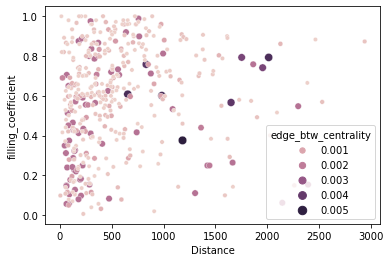

In [37]:
sns.scatterplot(data = edges_df, x = "Distance", y = "filling_coefficient", hue = "edge_btw_centrality", 
                size = "edge_btw_centrality")

## Get the largest connected component
The following cell will list all connected components of the passenger networks and sort by number of nodes. Thi is useful because we will be able to plot only the biggest one.

In [38]:
components = list(nx.strongly_connected_components(passenger_network))
largest_component = max(components, key=len)
subgraph = nx.Graph.subgraph(passenger_network, list(largest_component))

## Plot the airports network

In [44]:
%matplotlib notebook
def plot_nodes_and_edges(nodes_df, edges_df, nodes_attribute, edges_attribute, cmap_name = "tab20b"):
    
    def color_map_color(value, cmap_name=cmap_name, vmin=0, vmax=1):
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        cmap = cm.get_cmap(cmap_name)  # PiYG
        rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
        color = colors.rgb2hex(rgb)
        return color

    fig, ax = plt.subplots(figsize = (8, 7), 
                           subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth = 0.5)
    
    # Extent of continental US.
    ax.set_extent([-165, -50, 10, 60])
    
    sns.scatterplot(data = nodes_df, x = "Long", y = "Lat", size = nodes_attribute, 
                    hue = nodes_attribute, 
                    sizes = (10, 200), 
                    ax = ax,
                    edgecolor = "black",linewidth = 0.5,
                    palette = "Reds", transform = ccrs.PlateCarree())
    
    min_value = edges_df[edges_attribute].min()
    max_value = edges_df[edges_attribute].max()
    
    for i, row in edges_df.iterrows():
        first_node = row["Origin_airport"]
        last_node = row["Destination_airport"]
        
        ax.plot([nodes_df.loc[first_node]["Long"], nodes_df.loc[last_node]["Long"]],
                 [nodes_df.loc[first_node]["Lat"], nodes_df.loc[last_node]["Lat"]],
                 marker = None,
                 linewidth = 0.5, 
                 c = color_map_color(row[edges_attribute], vmin = min_value, vmax = max_value),
                 transform=ccrs.Geodetic() 
                 )

    plt.colorbar(cm.ScalarMappable(norm = colors.Normalize(vmin=min_value, vmax=max_value), 
                                   cmap=cmap_name),  boundaries = np.linspace(min_value, max_value, 19),
                 location = "bottom").set_label(edges_attribute)
    
    plt.tight_layout()

### Network plot - main cities & routes filling coefficient

<IPython.core.display.Javascript object>


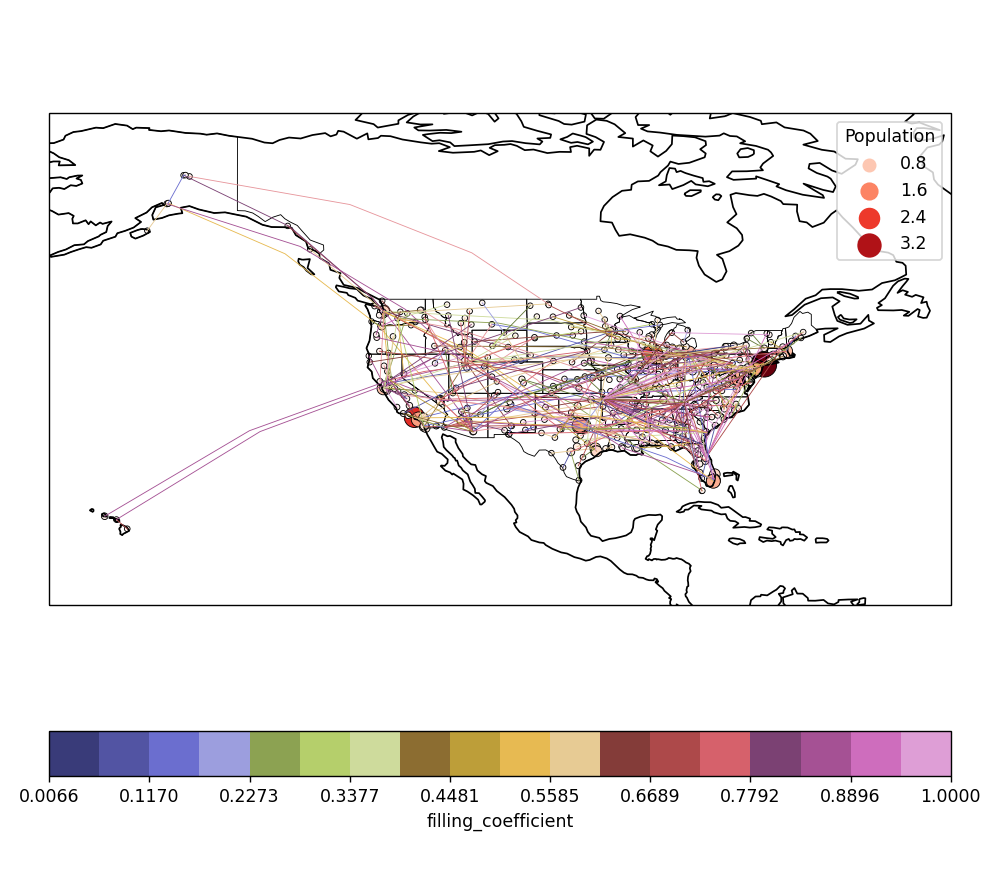

In [45]:
plot_nodes_and_edges(nodes_df, edges_df, "Population", "filling_coefficient")

### Network plot - centrality metrics

<IPython.core.display.Javascript object>


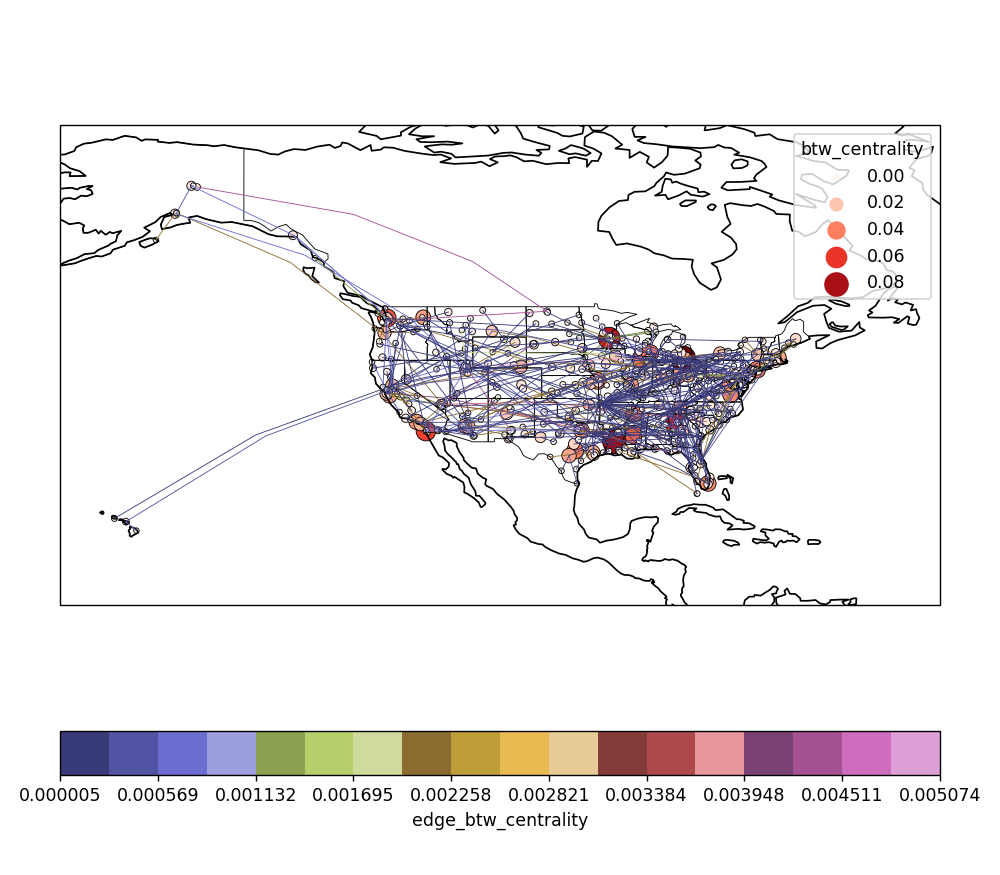

In [46]:
plot_nodes_and_edges(nodes_df, edges_df, "btw_centrality", "edge_btw_centrality")

## References
Federico Ciliberto, Emily E. Cook, Jonathan W. William, Network Structure and Consolidation in the U.S. Airline Industry, 1990-2015. Online at https://mpra.ub.uni-muenchen.de/83885/, MPRA Paper No. 83885, posted 11 Jan 2018 15:19 UTC.

https://medium.com/geekculture/network-visualization-using-networkx-and-cartopy-a9a8a53440b9

https://towardsdatascience.com/graphs-101-airline-transportation-network-5548739fd22e

https://towardsdatascience.com/catching-that-flight-visualizing-social-network-with-networkx-and-basemap-ce4a0d2eaea6